# Import all the libraries 

import all required libraries to transfer learn the Deep learning model using Pytorch library.

In [1]:
import mimetypes
from pathlib import Path
import os
import sys
import random
import shutil
from tempfile import TemporaryDirectory
import cv2
import matplotlib.pyplot as plt
import json
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import albumentations as A
import torch.nn as nn
from tqdm.notebook import trange, tqdm

In [2]:
!pip install xmltodict
import xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data retrieval from github repository

In [3]:
dataDir = TemporaryDirectory(dir='/content/sample_data', prefix='github_')
!git clone https://github.com/waruna-wickramasingha/facemask-detection.git $dataDir.name

Cloning into '/content/sample_data/github_93fsnldc'...
remote: Enumerating objects: 1710, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1710 (delta 0), reused 4 (delta 0), pack-reused 1706
Receiving objects: 100% (1710/1710), 394.58 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (846/846), done.
Updating files: 100% (1708/1708), done.


Below is a utility function to list all the files present in a given path with the desired extensions provided as a list

In [4]:
def getFilesList(path, desiredExtensionList):
  fileList = []
  for x in path.iterdir():
    if x.suffix.lower() in desiredExtensionList:
      fileList.append(x)
  return fileList

Below was arrangement of images and annotation files of this dataset.

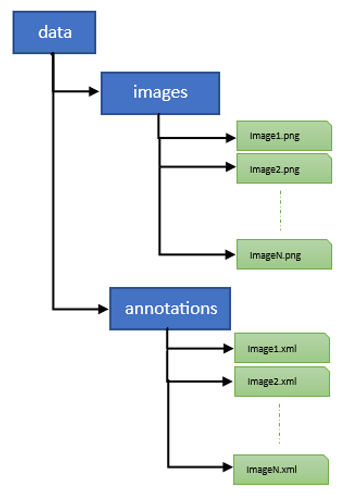

Get all the annotation files present in the dataset which are provided in PASCAL VOC format as xml files. These files contain bounding boxes and labels for each face present in the images.

In [5]:
annotationsPath = Path(dataDir.name+'/data/annotations')
annotationsPathList = getFilesList(annotationsPath, ['.xml'])
print(annotationsPathList)

[PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss281.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss678.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss297.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss686.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss196.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss704.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss512.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss174.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss837.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss523.xml'), PosixPath('/content/sample_data/github_93fsnldc/data/annotations/maksssksksss403.xml'), PosixPath('/content/sample_data

Get all image extentions using mimetypes library

In [6]:
image_extensions = [k for k,v in mimetypes.types_map.items() if 'image/' in v]
image_extensions

['.bmp',
 '.gif',
 '.ief',
 '.jpg',
 '.jpe',
 '.jpeg',
 '.heic',
 '.heif',
 '.png',
 '.svg',
 '.tiff',
 '.tif',
 '.ico',
 '.ras',
 '.pnm',
 '.pbm',
 '.pgm',
 '.ppm',
 '.rgb',
 '.xbm',
 '.xpm',
 '.xwd']

Get all images with above extentions from the dataset

In [7]:
imagesPath = Path(dataDir.name + '/data/images')
imagesPathList = getFilesList(imagesPath, image_extensions)

Lest view some of the items from that list

In [8]:
print(imagesPathList[:3])

[PosixPath('/content/sample_data/github_93fsnldc/data/images/maksssksksss256.png'), PosixPath('/content/sample_data/github_93fsnldc/data/images/maksssksksss512.png'), PosixPath('/content/sample_data/github_93fsnldc/data/images/maksssksksss436.png')]


Let's open a random annotation file to see its content.

In [9]:
random.seed(5)
with open(random.choice(annotationsPathList)) as fd:
  doc = xmltodict.parse(fd.read())
  print(json.dumps(doc, indent=4))

{
    "annotation": {
        "folder": "images",
        "filename": "maksssksksss50.png",
        "size": {
            "width": "400",
            "height": "292",
            "depth": "3"
        },
        "segmented": "0",
        "object": [
            {
                "name": "with_mask",
                "pose": "Unspecified",
                "truncated": "0",
                "occluded": "0",
                "difficult": "0",
                "bndbox": {
                    "xmin": "206",
                    "ymin": "83",
                    "xmax": "238",
                    "ymax": "114"
                }
            },
            {
                "name": "with_mask",
                "pose": "Unspecified",
                "truncated": "0",
                "occluded": "0",
                "difficult": "0",
                "bndbox": {
                    "xmin": "226",
                    "ymin": "51",
                    "xmax": "262",
                    "ymax": "82"
     

# Class Distribution

As can be seen, the object section in the above provide class and bounding boxes for each face present in the image. Using above structure, lets extract all the distinct class labels across all the annotation files to see their distribution.

In [10]:
classLabels = []
for f in annotationsPathList:
  with open(f) as fd:
    doc = xmltodict.parse(fd.read())
    objects = doc["annotation"]["object"]
    if type(objects) == list:
      for obj in objects:
        classLabels.append(obj['name'])
    else:
      classLabels.append(objects['name'])

In [11]:
classCounter = Counter(classLabels)
classCounter

Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})

Let's view above class distribution in graphical format.

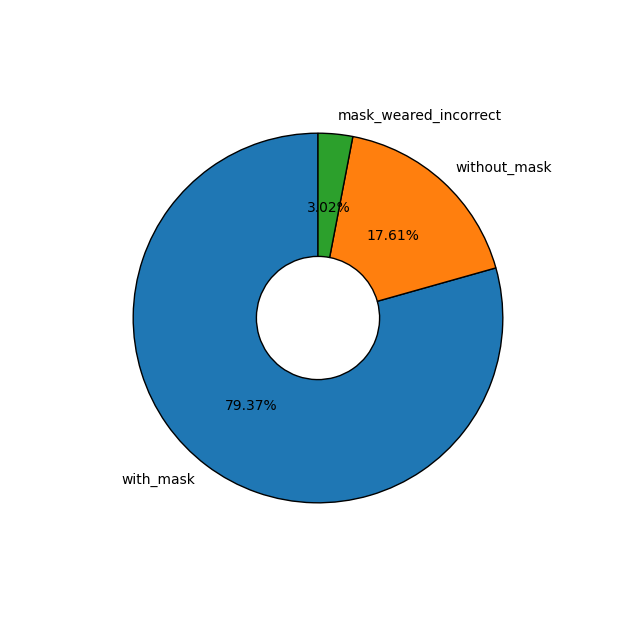

In [12]:
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pie(classCounter.values(), wedgeprops=dict(width=0.5, edgecolor='black'), labels=classCounter.keys(), radius=0.75, startangle = 90, autopct='%1.2f%%')
plt.show()

Accodring to above pie chart, it can be seen that the classes are not balanced and majority of data are with mask(79.3%) and there are a very few cases with masks worn incorrectly(3.2%)

Let's create few utility functions to show the provided face annotations in each image. Below is a fuction to add a patch to an axis object using the bounding box data and a color coding as,

1.   Faces with mask - Green color
2.   Faces witout mask - Red color

1.   Faces with mask worn incorrectly - Yellow color












In [13]:
def addPatch(ax, obj):
  x,y,w,h = list(map(int, obj["bndbox"].values()))
  boxColor = ""
  label = ""
  if obj["name"] == "with_mask":
    boxColor = "green"
    label = "With Mask"
  elif obj["name"] == "without_mask":
    boxColor = "red"
    label = "Without Mask"
  elif obj["name"] == "mask_weared_incorrect":
    boxColor = "yellow"
    label = "Mask Weared Incorrectly"
  else:
    raise Exception("Unknown class name found!")

  mpatch = mpatches.Rectangle((x,y), w-x, h-y, linewidth=1.5, edgecolor=boxColor, facecolor="none")
  ax.add_patch(mpatch)
  rx, ry = mpatch.get_xy()
  ax.annotate(label, (rx, ry), weight='bold', color=boxColor, fontsize=10, ha='left', va='baseline')

Below method is to open the corresponding image for a given annotation file and to add patches around the faces in that image with the above color encoding.

In [14]:
def show_class_with_bbox(annotationFile, imagesRoot = dataDir.name + '/data/images/'):
  with open(annotationFile) as fd:
    doc = xmltodict.parse(fd.read())
    imagePath = imagesRoot + doc['annotation']['filename']
    image = plt.imread(imagePath)
    fig,ax = plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(5, 5)
    ax.imshow(image)
    objects = doc["annotation"]["object"]

    if type(objects) == list:
      for obj in objects:
        addPatch(ax, obj)
    else:
      addPatch(ax, objects)

Lets see above funtion in action for a sample of 5 annotation files.

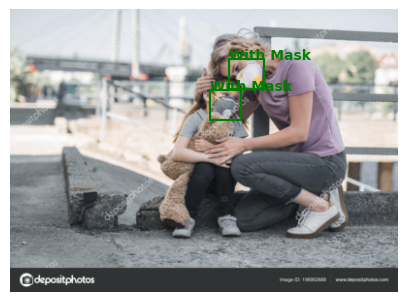

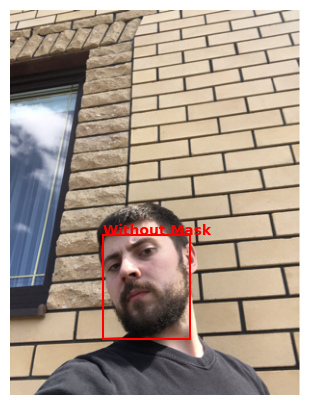

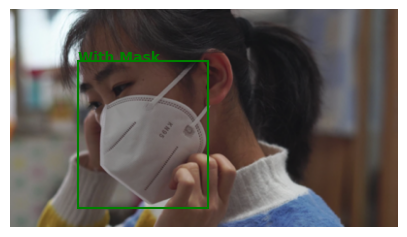

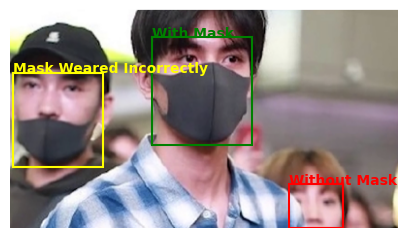

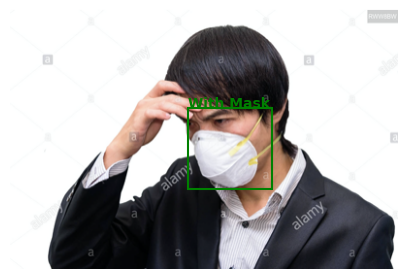

In [15]:
random.seed(5)
for annotation in random.sample(annotationsPathList, 5):
  show_class_with_bbox(annotation)

# Extract faces from images to model training

Let's create few temporary directories to extract and save the face images from the dataset. Here I will be creating 3 directories for each class inside a directory called cropped_*

In [16]:
croppedImagesPath = TemporaryDirectory(dir='/content/sample_data', prefix='cropped_')
correctMaskPath = TemporaryDirectory(dir=croppedImagesPath.name, prefix='withMask_')
noMaskPath = TemporaryDirectory(dir=croppedImagesPath.name, prefix='withoutMask_')
incorrectMaskPath = TemporaryDirectory(dir=croppedImagesPath.name, prefix='incorrectMask_')

Below is a utility function to crop a face from a given image using the bounding box information taken from the object annotations(PASCAL VOC).

In [17]:
croppedImageSavingIndex = 1

def saveCroppedImage(origImage, object):
  x, y, w, h = list(map(int, object["bndbox"].values()))
  label = object["name"]
  croppedFaceImage = transforms.functional.crop(origImage, y, x, h-y, w-x)
  
  global croppedImageSavingIndex
  imageName = "{}_{}.png".format(label, croppedImageSavingIndex)
  croppedImageSavingIndex += 1

  if label == 'with_mask':
    imageSavePath = "{}{}{}".format(correctMaskPath.name, os.sep, imageName)
  elif label == 'without_mask':
    imageSavePath = "{}{}{}".format(noMaskPath.name, os.sep, imageName)
  elif label == 'mask_weared_incorrect':
    imageSavePath = "{}{}{}".format(incorrectMaskPath.name, os.sep, imageName)
  else:
    raise Exception('Incorrect label found!')
  
  try:
    croppedFaceImage.save(imageSavePath)
  except:
    raise Exception('Failed to save image at path {}'.format(imageSavePath))

Below function will open an annotation file and call saveCroppedImage for each face present its image file.

In [18]:
def save_faces(annotationFile, imagesRoot = dataDir.name + '/data/images/'): 
  with open(annotationFile) as fd:
    doc = xmltodict.parse(fd.read())
    imagePath = imagesRoot + doc['annotation']['filename']
    origImage = Image.open(imagePath).convert("RGB")
    if type(doc["annotation"]["object"]) == list:
      objects = doc["annotation"]["object"]
      for k in range(len(objects)):
        saveCroppedImage(origImage, objects[k])
    else:
      obj = doc["annotation"]["object"]
      saveCroppedImage(origImage, obj)

Let's drive the above code using each of the annotation files.

In [19]:
for an in tqdm(annotationsPathList):
  save_faces(an)

  0%|          | 0/853 [00:00<?, ?it/s]

Let's check the number of images cropped and saved in the temp directories created

In [20]:
len(getFilesList(Path(correctMaskPath.name), ['.png'])), len(getFilesList(Path(noMaskPath.name), ['.png'])), len(getFilesList(Path(incorrectMaskPath.name), ['.png']))

(3232, 717, 123)

In [21]:
classCounter

Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})

Therefore, it can be seen that, the number of cropped faces for each class match to the class distribution I have calculated above. All good so far.

# Train Test Split

**Let's re-arrange the cropped images of the faces into train and test directories using 80% train and 20% test split**

In [22]:
train_split = 0.8

Data Arrangement for model training is planned to be arranged like below

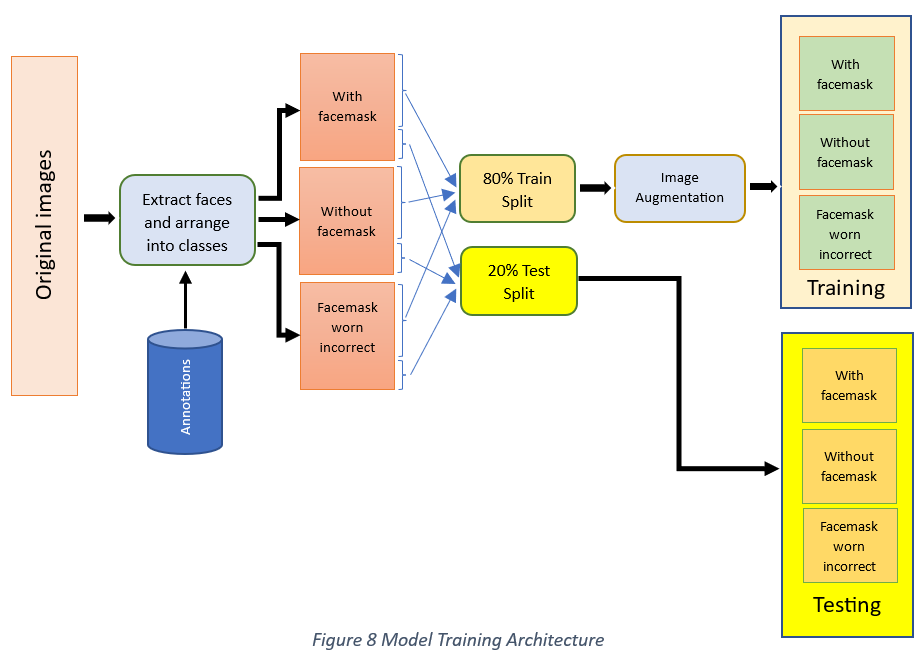

**Let's create directory structures to save train and test images**



In [23]:
trainImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Train_')
trainCorrectMaskPath = TemporaryDirectory(dir=trainImagesRoot.name, prefix='withMask_')
trainNoMaskPath = TemporaryDirectory(dir=trainImagesRoot.name, prefix='withoutMask_')
trainIncorrectMaskPath = TemporaryDirectory(dir=trainImagesRoot.name, prefix='incorrectMask_')

testImagesRoot = TemporaryDirectory(dir='/content/sample_data', prefix='Test_')
testCorrectMaskPath = TemporaryDirectory(dir=testImagesRoot.name, prefix='withMask_')
testNoMaskPath = TemporaryDirectory(dir=testImagesRoot.name, prefix='withoutMask_')
testIncorrectMaskPath = TemporaryDirectory(dir=testImagesRoot.name, prefix='incorrectMask_')

Below is a utility function which would re arrange the given original files for a class in to corresponding training directory and test directory with 80% train split for each class. This is similar to a Stratified split.

In [24]:
def reArrangeImagesIntoTrainTest(imagesList, trainDir, testDir, trainSplit=0.8):
  """
  This method would split the original list of images provided in imagesList 
  by moving them into trainDir and testDir keeping the original file name.
  """
  print("Train Directory=", trainDir)
  print("Test Directory=", testDir)

  imagesList = np.array(imagesList)
  randSelections = np.random.permutation(len(imagesList))

  trainTestCutPoint = int(len(imagesList)*trainSplit)
  trainImages = imagesList[randSelections[:trainTestCutPoint]]

  try:
    for p in trainImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = trainDir.name + os.sep + imageName
      shutil.move(p, newPath)

    testImages = imagesList[randSelections[trainTestCutPoint:]]  
    for p in testImages:
      imageName = str(p).split(os.sep)[-1]
      newPath = testDir.name + os.sep + imageName
      shutil.move(p, newPath)
  except:
    raise Exception("Failed to move images into train={} and test={} directories".
                    format(trainDir.name, testDir.name))

Rearranging images with correct masks

In [25]:
reArrangeImagesIntoTrainTest(getFilesList(Path(correctMaskPath.name), ['.png']), 
                             trainCorrectMaskPath, 
                             testCorrectMaskPath, 
                             train_split)

Train Directory= <TemporaryDirectory '/content/sample_data/Train_j7zg64hy/withMask_4h3u07kz'>
Test Directory= <TemporaryDirectory '/content/sample_data/Test_sq2atxhz/withMask_2mlpnt_8'>


Rearranding images with no masks

In [26]:
reArrangeImagesIntoTrainTest(getFilesList(Path(noMaskPath.name), ['.png']), 
                             trainNoMaskPath, 
                             testNoMaskPath, 
                             train_split)

Train Directory= <TemporaryDirectory '/content/sample_data/Train_j7zg64hy/withoutMask__1v3jmxw'>
Test Directory= <TemporaryDirectory '/content/sample_data/Test_sq2atxhz/withoutMask_xijq414z'>


Rearranding images with incorrect masks

In [27]:
reArrangeImagesIntoTrainTest(getFilesList(Path(incorrectMaskPath.name), ['.png']), 
                             trainIncorrectMaskPath, 
                             testIncorrectMaskPath, 
                             train_split)

Train Directory= <TemporaryDirectory '/content/sample_data/Train_j7zg64hy/incorrectMask_9bnclmgu'>
Test Directory= <TemporaryDirectory '/content/sample_data/Test_sq2atxhz/incorrectMask_4ql_x3xj'>


After restructuring the images into train and test directories, we can now remove the temporary directory used to hold the extracted faces

In [28]:
croppedImagesPath.cleanup()

**Let's view number of images present after re arranging original images into train and test directories**


**Train Images**

In [29]:
tr_im_counts = (len(getFilesList(Path(trainCorrectMaskPath.name), ['.png'])),
                len(getFilesList(Path(trainNoMaskPath.name), ['.png'])),
                len(getFilesList(Path(trainIncorrectMaskPath.name), ['.png'])))
tr_im_counts

(2585, 573, 98)

**Test Images**

In [30]:
test_im_couts = (len(getFilesList(Path(testCorrectMaskPath.name), ['.png'])), 
                  len(getFilesList(Path(testNoMaskPath.name), ['.png'])),
                  len(getFilesList(Path(testIncorrectMaskPath.name), ['.png'])))
test_im_couts

(647, 144, 25)

# Data Augmentation

**Next task is handling the class imbalance between train classes.** 
I have create a method which can augment a given directory into the number of required target number as given in 'numberOfTargetSamples' by applying the augmentaion pipeline given via 'augmentationPipeline'. All the augmented images will be saved by creating a new directory under the root directory as specified by 'outputDirRoot'. The diagram shown below explain the same policy for data augmentation.


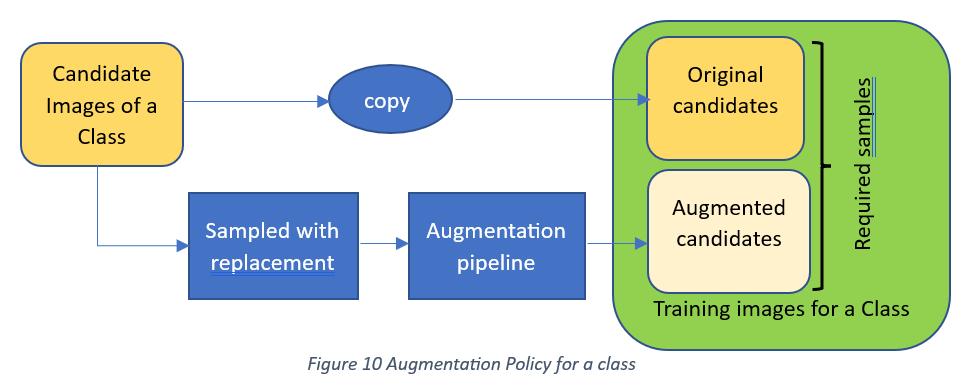

In [31]:
def doAugmentation(inputDir: str, outputDirRoot: str, augmentationPipeline, numberOfTargetSamples):
  """
  This function is to perform image augmentations for the images present at the 'inputDir' 
  into the root location as specified at 'outputDirRoot' using the function 'augmentationPipeline' 
  which takes in an image and output an augmented image. The new directory will be created with the same prefix
  as the input directory and it will contain all the original images plus a number of augmented images 
  such that 'numberOfTargetSamples' is reached
  """
  inputDirPath = Path(inputDir)
  originalImagePaths = []
  im_ext = [k for k,v in mimetypes.types_map.items() if 'image/' in v]

  for x in inputDirPath.iterdir():
      if x.suffix.lower() in im_ext:
          originalImagePaths.append(x)

  origLMDir = inputDir.split(os.sep)[-1]

  try:
      augLMDir = TemporaryDirectory(dir=outputDirRoot, prefix="{}_Aug_".format(origLMDir))
  except:
      raise Exception("Error creating temp dir for augmentations")

  print("Original Directory={}, Augmented Directory={}".format(inputDir, augLMDir.name))

  for im in originalImagePaths:
      imageName = str(im).split(os.sep)[-1]
      outputImagePath = augLMDir.name + os.sep + imageName
      
      try:
          shutil.copy(im, outputImagePath)
      except:
          raise Exception("Failed to copy original file {} to {}".format(im, outputImagePath))

  augCandidates = random.choices(originalImagePaths, k=(numberOfTargetSamples-len(originalImagePaths)))
  aug_ind = 0

  for impath in augCandidates:
      im = cv2.imread(str(impath))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

      augmentedImage = augmentationPipeline(im)
      imageName, imageExt = str(impath).split(os.sep)[-1].split('.')
      outputImagePath = augLMDir.name + os.sep + 'aug' + str(aug_ind) + '_' + imageName + '.' + imageExt
      aug_ind += 1
      try:
          cv2.imwrite(outputImagePath, cv2.cvtColor(augmentedImage, cv2.COLOR_RGB2BGR))
      except:
          raise Exception("Failed to save augmented image to {}".format(outputImagePath))
      
  return augLMDir

Below is an augmentation pipeline created from Albumentation library which is capable of creating a different image each time when an input image is passed to the pipeline.

In [32]:
transform = A.Compose(
        [A.RandomRotate90(),
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.4, p=0.7),
        A.CLAHE(p=0.7),
        A.HorizontalFlip(p=0.7),
        A.Transpose(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),
        A.Blur(blur_limit=3)])

The method below would act as a wrapper function which would take an image as an input and apply the augmentation pipeline on it while returning an augmented version for that image.

In [33]:
def augmentationPipeline(image):
  return transform(image=image)['image']

Let's create a temporary dir to save all the augmentations of the training images

In [34]:
augmentationDirRoot = TemporaryDirectory(dir='/content/sample_data', prefix='augmentations')
augmentationDirRoot.name

'/content/sample_data/augmentationsrm6wz7p3'

In [35]:
p = Path(trainImagesRoot.name)
augDirs = []
for subDir in p.iterdir():
  d = doAugmentation(str(subDir), augmentationDirRoot.name, augmentationPipeline, max(tr_im_counts))
  augDirs.append(d)

Original Directory=/content/sample_data/Train_j7zg64hy/incorrectMask_9bnclmgu, Augmented Directory=/content/sample_data/augmentationsrm6wz7p3/incorrectMask_9bnclmgu_Aug_6lutfeu1
Original Directory=/content/sample_data/Train_j7zg64hy/withMask_4h3u07kz, Augmented Directory=/content/sample_data/augmentationsrm6wz7p3/withMask_4h3u07kz_Aug_owqzuwgb
Original Directory=/content/sample_data/Train_j7zg64hy/withoutMask__1v3jmxw, Augmented Directory=/content/sample_data/augmentationsrm6wz7p3/withoutMask__1v3jmxw_Aug_3bosncfv


Below is a utility function to show the original image and some of its augmentations.

In [36]:
#Function to display some augmented images for n number of random classes in the dataset.
def displayAugmentedImages(augmentationDir:str, num:int):
  augmentationDir = Path(augmentationDir)
  label_count = num
  try:
    for x in augmentationDir.iterdir():
      if(label_count==0):
        break;
      label_count-=1
      for y in x.iterdir():
          aug_arr=[]
          if('aug' not in y.name):
            for z in x.iterdir():
              if(str(y.name) in z.name and 'aug' in z.name):
                aug_arr.append(z)

            temp = Image.open(y)
            # temp = ImageOps.exif_transpose(temp)
            plt.subplot(1,min(5,len(aug_arr)+1),1) # nx5 subplot to display the images
            plt.imshow(temp)   #first image in each row of subplot is the original image
            # plt.title(im_name_to_class[y.name]) # add class label as the title

            for i in range(min(4,len(aug_arr))): #display augmented images in the same row 
              plt.axis('off')
              temp = Image.open(aug_arr[i])
              # temp = ImageOps.exif_transpose(temp)              
              plt.subplot(1,min(5,len(aug_arr)+1),i+2) 
              plt.imshow(temp)
           
            #ax.set_xlabel(os.path.basename(y))
            plt.axis('off')
            plt.show()
            break;
      
  except:
    raise Exception("Failed to display results")
  finally:
    print("Successfully displayed the augmented images")

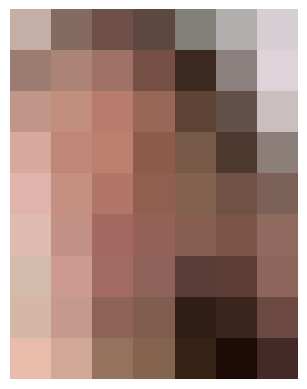

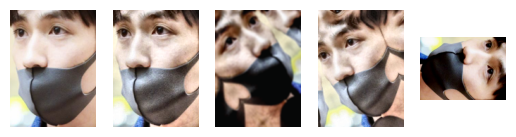

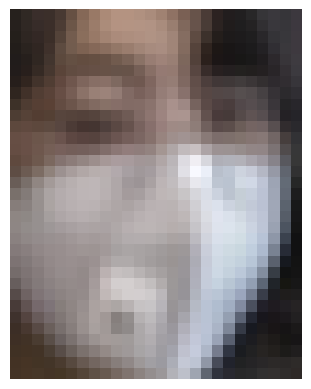

Successfully displayed the augmented images


In [37]:
displayAugmentedImages(augmentationDirRoot.name, 10)

Having applied image augmentation on top of the training dataset, lets have a look at the class distrubution of the new training data set.

In [38]:
print("Training Class distribution after Augmentations..")

allAugmentedTrImagePaths = []

classCountsAfterAugmentation = dict()
for subDir in augDirs:
  print("Class type =", subDir.name.split(os.sep)[-1].split('_')[0], end=' , ')
  temp = getFilesList(Path(subDir.name), ['.png'])
  allAugmentedTrImagePaths.extend(temp)
  print("Images count", len(temp))
  classCountsAfterAugmentation[subDir.name.split(os.sep)[-1].split('_')[0]] = len(temp)

Training Class distribution after Augmentations..
Class type = incorrectMask , Images count 2585
Class type = withMask , Images count 2585
Class type = withoutMask , Images count 2585


In [39]:
classCountsAfterAugmentation

{'incorrectMask': 2585, 'withMask': 2585, 'withoutMask': 2585}

In [40]:
def visualizeDict(countDict):
  _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  background_color = '#faf9f4'
  ax1.set_facecolor(background_color)
  ax2.set_facecolor(background_color)

  ax1.pie(countDict.values(), 
        wedgeprops = dict(width=0.5, edgecolor='black'), 
        labels = countDict.keys(), 
        radius = 0.75, 
        startangle = 90,
        autopct = '%1.2f%%')

  ax1 = plt.bar(countDict.keys(), 
                countDict.values(),
                color ='green', width = 0.2)
  plt.show()

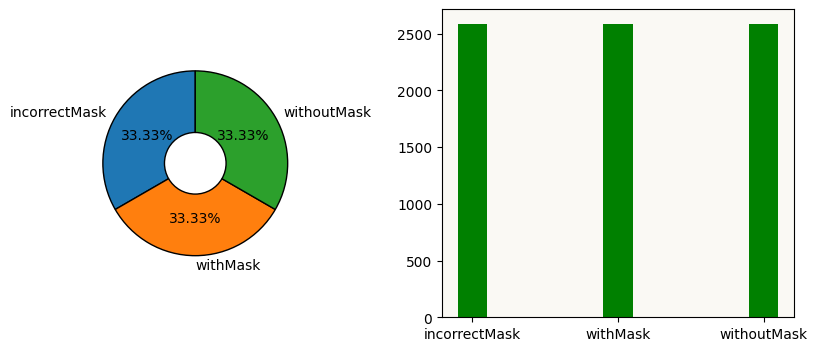

In [41]:
visualizeDict(classCountsAfterAugmentation)

Therefore, now it can be seen that the 3 classes are equally balanced across each having 2585 images.

I did not touch the training dataset with image augmentation. Let's have a look at their class distribution.

**Let's view testing class distribution**

In [42]:
p = Path(testImagesRoot.name)
testDirs = [subDir for subDir in p.iterdir()]
testDirs

[PosixPath('/content/sample_data/Test_sq2atxhz/withMask_2mlpnt_8'),
 PosixPath('/content/sample_data/Test_sq2atxhz/incorrectMask_4ql_x3xj'),
 PosixPath('/content/sample_data/Test_sq2atxhz/withoutMask_xijq414z')]

In [43]:
allTestingImagePaths = []
classCountsTesting = dict()

for subDir in testDirs:
  print("Class type =", subDir.name.split(os.sep)[-1].split('_')[0], end=' , ')
  temp = getFilesList(subDir, ['.png'])
  allTestingImagePaths.extend(temp)
  print("Images count", len(temp))
  classCountsTesting[subDir.name.split(os.sep)[-1].split('_')[0]] = len(temp)

Class type = withMask , Images count 647
Class type = incorrectMask , Images count 25
Class type = withoutMask , Images count 144


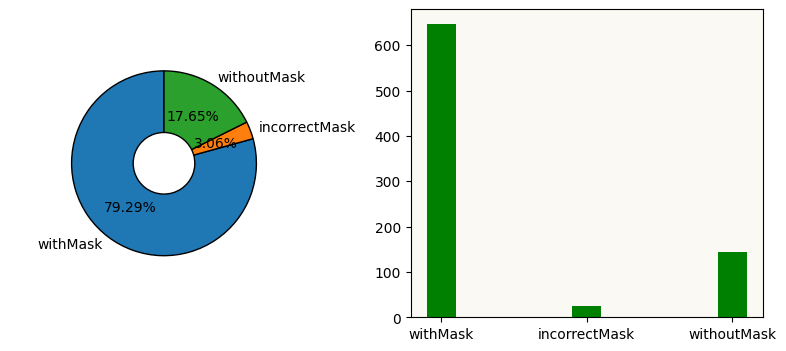

In [44]:
visualizeDict(classCountsTesting)

An it was expected, the validation data set follows the same class distribution like it was on the original dataset due to stratified sampling approach I followed when splitting the dataset.

Let's create data structures to convert index to class and class to index. This is useful when creating the dataset

In [45]:
i2c = ['withMask', 'withoutMask', 'incorrectMask']
c2i = {v:i for i,v in enumerate(i2c)}

In [46]:
i2c

['withMask', 'withoutMask', 'incorrectMask']

In [47]:
c2i

{'withMask': 0, 'withoutMask': 1, 'incorrectMask': 2}

# Pytorch Dataset and Data Loaders

**Create Dataset class for facemask images so that pytorch libraray can load the images as pytorch tensors**

In [48]:
import torch as tc
from torch.utils.data import Dataset, DataLoader

In [49]:
class FaceMaskDataSet(Dataset):
  def __init__(self, imPathList, c2i, transform):
    self.x = imPathList
    self.c2i = c2i
    self.transform = transform

  def __len__(self): 
    return len(self.x)
    
  def __getitem__(self, ix): 
    image_filepath = str(self.x[ix])
    image = Image.open(image_filepath)
    label = image_filepath.split(os.sep)[-2].split('_')[0]
    label = self.c2i[label]
    if self.transform is not None:
      image = self.transform(image)
    
    return image, label

Above data loader is a wrapper which defines the capability to output a Tensor from a list of image paths.

Since all the models used in this project are pre trined on imagenet data set, all the input images need to be normalized with image net stats before being trained with the DNNs.

In [50]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Before loading an image to the Neural network, it needs to go through the resizing, normalization and conversion to Tensor activities. They can be defined in a single pipeline as below which is used by the Dataset clas I have defined above.

In [51]:
transf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
    ])

train_ds  = FaceMaskDataSet(allAugmentedTrImagePaths, c2i, transf)
test_ds  = FaceMaskDataSet(allTestingImagePaths, c2i, transf)

Let's have a look at the size of the datasets for model training and validation.

In [52]:
len(train_ds), len(test_ds)

(7755, 816)

**Images are loaded as batched into the NN. Define the batch size as below**

In [53]:
bs = 16

**Data loaders are used to load images as batch of tensors rather than loading the whole dataset at once into memory.**

I created two different data loader one for training with 16 
batch size and another one for validation dataset with twice the size of batch size for training.

In [54]:
tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

## Pytorch Model zoo

Let's have a look at all the pre trained models available at Pytorch model zoo

In [55]:
from torchvision.models import list_models
list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

## Utility functions for Pytorch model training

Below is a utility function that can be used to train a given Neural Network for one epoch in forward pass and update its parameters by back propagating the loss

In [56]:
def one_epoch(net, loss, dl, opt=None, metric=None):   
  if opt: net.train()  # only affects some layers
  else:   net.eval()

  L, M = [], []
  for xb, yb in tqdm(iter(dl), leave=False):
    xb, yb = xb.cuda(), yb.cuda()
    if opt:
      y_ = net(xb)
      l = loss(y_, yb)
      opt.zero_grad()
      l.backward()
      opt.step()
    else:
      with tc.no_grad():
        y_ = net(xb)
        l = loss(y_, yb)
    L.append(l.detach().cpu().numpy())
    if metric: 
      M.append(metric(y_, yb).cpu().numpy())
          
  return L, M

Below is a model fit function that uses one_epoch function defined above to fit a given NN using the training data loader while evaluating its results using the validation data loader for the number of epochs provided as an argument.
When plot=True, it will show the training and validation accuracy in a line chart.

In [57]:
accuracy = lambda y_,yb: (y_.max(dim=1)[1] == yb).float().mean()

def fit(net, tr_dl, val_dl, loss=nn.CrossEntropyLoss(), epochs=10, lr=3e-3, wd=1e-3, plot=True):
  opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
  Ltr_hist, Lval_hist = [], []
  for epoch in trange(epochs):
    Ltr,  _    = one_epoch(net, loss, tr_dl,  opt)
    Lval, Aval = one_epoch(net, loss, val_dl, None, accuracy)
    Ltr_hist.append(np.mean(Ltr))
    Lval_hist.append(np.mean(Lval))
    print(f'epoch: {epoch}\ttraining loss: {np.mean(Ltr):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
      
  # plot the losses     
  if plot:
    _,ax = plt.subplots(1,1,figsize=(16,4))
    ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
    ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
    ax.grid('on')
    ax.set_xlim(left=1, right=len(Ltr_hist))
    ax.legend(['training loss', 'validation loss']);
      
  return Ltr_hist, Lval_hist

Below are three utility functions to freeze the layers of a neural network so that gradients are not calculated and weights are not adjusted in them.

In [58]:
def _freeze(md, fr=True):
  ch = list(md.children())
  for c in ch: _freeze(c, fr)
  if not ch and not isinstance(md, tc.nn.modules.batchnorm.BatchNorm2d):  # not freezing the BatchNorm layers!
    for p in md.parameters(): 
      p.requires_grad = not fr

def freeze_to(md, ix=-1, fr=True):
  ch_all = list(md.children())
  for ch in ch_all[:ix]:
    _freeze(ch, fr)

Below is an unfreeze funtion which can unfreeze the layers of a NN so that those layers can be trained.

In [59]:
def unfreeze_to(md, ix=-1):
    ch_all = list(md.children())
    for ch in ch_all[:ix]: _freeze(ch, False)

# Model Transfer Learning

**Let's do transfer learning on few state-of-the-art deep learning models for this problem**


1.   ResNet-50
2.   MobileNet-v3



## ResNet-50 Model

In [60]:
models.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 264MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 0	training loss: 0.5176	validation loss: 0.1243	validation accuracy: 0.95


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 1	training loss: 0.3375	validation loss: 0.3159	validation accuracy: 0.89


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 2	training loss: 0.3131	validation loss: 0.2416	validation accuracy: 0.92


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 3	training loss: 0.2915	validation loss: 0.1858	validation accuracy: 0.94


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 4	training loss: 0.2938	validation loss: 0.3515	validation accuracy: 0.88


([0.5175864, 0.33752528, 0.31307167, 0.29145056, 0.293806],
 [0.124314815, 0.31587917, 0.24159206, 0.18581088, 0.35154822])

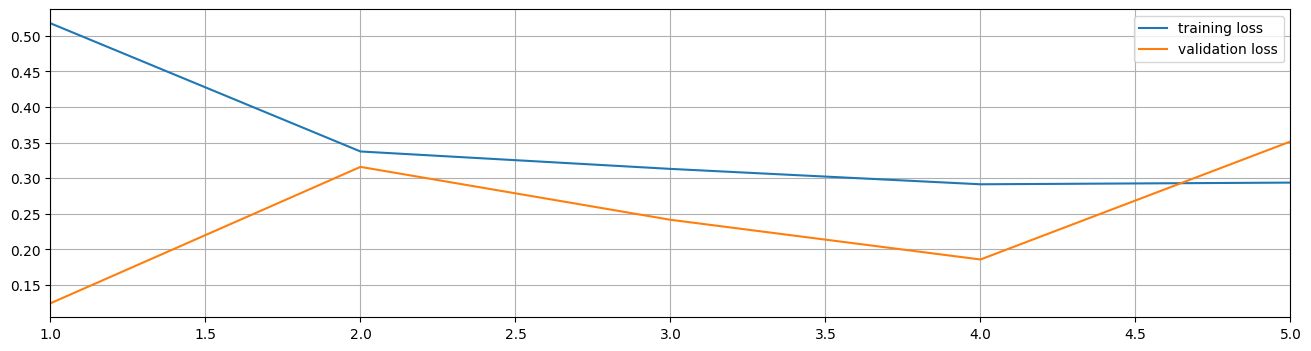

In [61]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, 3)
freeze_to(resnet50, -1, True)
resnet50 = resnet50.cuda()

bs = 16
tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

fit(resnet50, tr_dl, val_dl, epochs=5)

## MobileNet-V3-Large Model

In [62]:
models.mobilenet_v3_large()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:02<00:00, 7.43MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 0	training loss: 0.6041	validation loss: 0.4539	validation accuracy: 0.81


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 1	training loss: 0.3774	validation loss: 0.6281	validation accuracy: 0.73


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 2	training loss: 0.3251	validation loss: 0.1296	validation accuracy: 0.96


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 3	training loss: 0.3161	validation loss: 0.9143	validation accuracy: 0.60


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 4	training loss: 0.3250	validation loss: 0.2203	validation accuracy: 0.93


([0.60405284, 0.3774296, 0.32508552, 0.31606025, 0.32501933],
 [0.45385537, 0.6281283, 0.12962422, 0.9142697, 0.22033437])

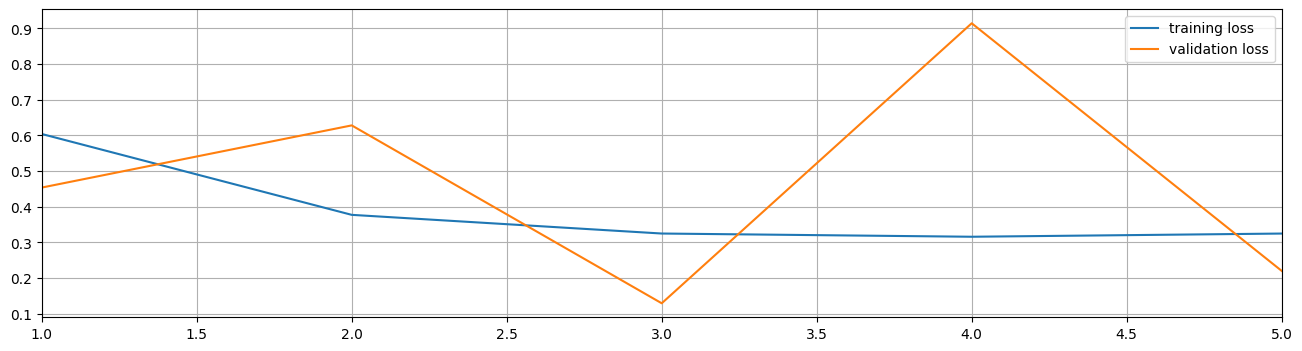

In [63]:
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_large.classifier[3] = nn.Linear(1280, 3)
freeze_to(mobilenet_v3_large, -1, True)
mobilenet_v3_large = mobilenet_v3_large.cuda()

bs = 16
tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

fit(mobilenet_v3_large, tr_dl, val_dl, epochs=5)

## MobileNet-v3-Small Model

In [64]:
models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 52.7MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 0	training loss: 0.5926	validation loss: 0.9761	validation accuracy: 0.60


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 1	training loss: 0.3909	validation loss: 1.0994	validation accuracy: 0.51


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 2	training loss: 0.3454	validation loss: 0.8662	validation accuracy: 0.71


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 3	training loss: 0.3359	validation loss: 0.3171	validation accuracy: 0.89


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 4	training loss: 0.3371	validation loss: 0.5931	validation accuracy: 0.81


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 5	training loss: 0.3231	validation loss: 0.1886	validation accuracy: 0.94


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 6	training loss: 0.3200	validation loss: 0.3880	validation accuracy: 0.85


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 7	training loss: 0.3117	validation loss: 0.5210	validation accuracy: 0.79


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 8	training loss: 0.3190	validation loss: 0.1608	validation accuracy: 0.96


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 9	training loss: 0.3080	validation loss: 0.2557	validation accuracy: 0.92


([0.5926107,
  0.39091986,
  0.34541583,
  0.33590296,
  0.3371121,
  0.323095,
  0.3199928,
  0.31169695,
  0.31897724,
  0.30804822],
 [0.97610146,
  1.099413,
  0.86615396,
  0.31707442,
  0.5931005,
  0.18858677,
  0.38798517,
  0.52102846,
  0.16083847,
  0.25567433])

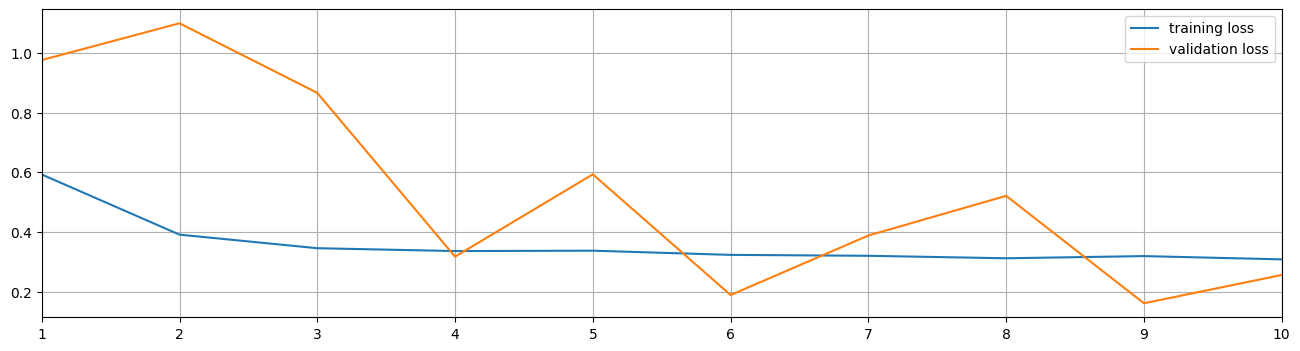

In [65]:
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)

mobilenet_v3_small.classifier[3] = nn.Linear(1024, len(i2c))
freeze_to(mobilenet_v3_small, -1, True)
mobilenet_v3_small = mobilenet_v3_small.cuda()

bs = 16
tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

fit(mobilenet_v3_small, tr_dl, val_dl, epochs=10)

## Inception V3 Model

In [66]:
models.inception_v3()

/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [67]:
# bs = 16
# tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
# val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)

# inception_v3 = models.inception_v3(pretrained=False)
# inception_v3.AuxLogits.fc = nn.Linear(768, len(i2c))

# inception_v3.fc = nn.Linear(2048, len(i2c))
# freeze_to(inception_v3, -1, True)

# inception_v3 = inception_v3.cuda()

# fit(inception_v3, tr_dl, val_dl, epochs=10)

## Pick the best model from and retrain

** Select the best mode from the above and re-train with a lower learning rate by unfreezing the inner layers except for the last layer.**

In [68]:
#select the best model from above ...

# best_model = resnet50         
best_model = mobilenet_v3_small

unfreeze_to(best_model, -1)  # unfreeze

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 0	training loss: 0.3019	validation loss: 0.1405	validation accuracy: 0.96


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 1	training loss: 0.2289	validation loss: 0.1432	validation accuracy: 0.95


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 2	training loss: 0.1896	validation loss: 0.1190	validation accuracy: 0.96


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

epoch: 3	training loss: 0.1542	validation loss: 0.1278	validation accuracy: 0.96


([0.30190217, 0.22886746, 0.18957457, 0.1542401],
 [0.14048304, 0.14321327, 0.11899804, 0.12784654])

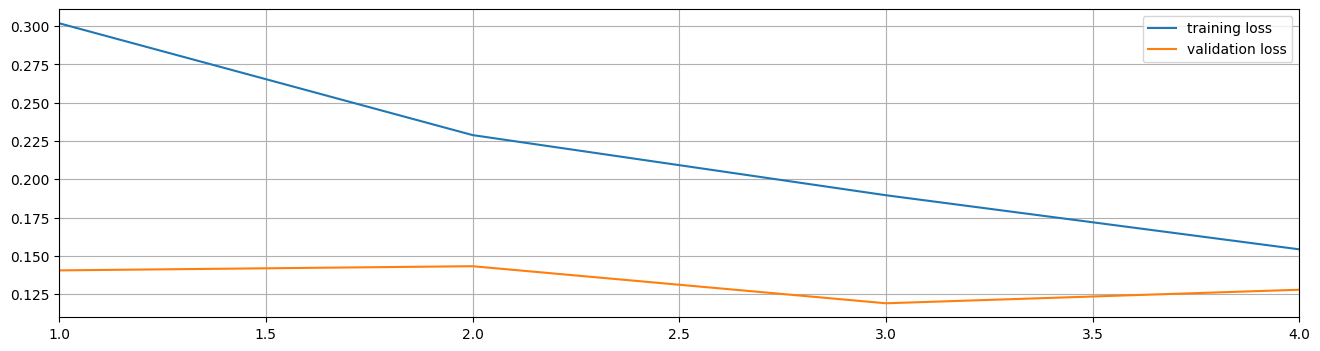

In [69]:
bs = 16
tr_dl  = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=2)
val_dl = DataLoader(test_ds, batch_size=2*bs, shuffle=False, num_workers=2)
fit(best_model.cuda(), tr_dl, val_dl, epochs=4, wd=1e-3, lr=0.0001)

In [70]:
tc.save(best_model, '/content/sample_data/AIBestmodel.pt')

# Inferencing

In [71]:
from itertools import chain

def get_preds(net, dl, with_x=False):  # with_x=True returns input images too
    # store requires_grad and network mode
    training_stored = net.training
    net.eval()
    
    Y, Y_, X = [], [], []
    dl_it = iter(dl)
    for xb, yb in tqdm(dl_it, leave=False):
        xb = xb.cuda()
        yb = yb.cuda() #todo check
        Y.append(yb.detach().cpu())
        with tc.no_grad():
          y_ = net(xb)
        Y_.append(y_.detach().cpu())
        if with_x: X.append(xb.detach().cpu())
        
    if training_stored: net.train()
        
    out = [tc.cat(Y_), Y]
    if with_x: out.append(tc.stack(list(chain(*X))))
    return tuple(out)

In [72]:
val_dl = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2)
Y_, Y, X = get_preds(best_model, val_dl, with_x=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [73]:
Y_.shape, len(Y), Y[0].shape, X.shape

(torch.Size([816, 3]), 7, torch.Size([128]), torch.Size([816, 3, 128, 128]))

In [74]:
tar_cls = tc.stack(list(chain(*[y for y in Y])))  # unpack the labels (they come as list of lists)
tar_cls

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [75]:
Y_.shape, tar_cls.shape, X.shape

(torch.Size([816, 3]), torch.Size([816]), torch.Size([816, 3, 128, 128]))

In [76]:
actual = tar_cls.numpy()
predicted = Y_.max(dim=1)[1].numpy()

## Recall and F1-Score  

In [77]:
from sklearn.metrics import recall_score, f1_score

recall_score(actual, predicted, average='weighted')

0.9632352941176471

In [78]:
f1_score(actual, predicted, average='weighted')

0.9661395039941246

## Confusion matrix

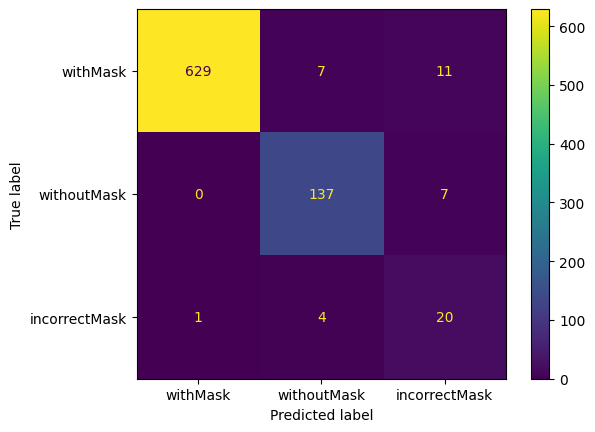

In [79]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = c2i.keys())

cm_display.plot()
plt.show()

In [80]:
import torch.nn.functional as F

def myloss(inp_cls, tar_cls, reduction='mean'):   
    loss_cls = F.cross_entropy(inp_cls, tar_cls.squeeze(), reduction=reduction)  # classification loss
    return loss_cls

In [81]:
accuracy(Y_, tar_cls)

tensor(0.9632)

In [82]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

In [83]:
def denorm(x, stats=imagenet_stats):
    return x * tc.Tensor(stats[1])[:,None,None] + tc.Tensor(stats[0])[:,None,None]

def show_results(Y_, Y, X):
    cnt = len(Y_)
    _, ax = plt.subplots(cnt,2,figsize=(16,6*cnt))

    for ix in range(cnt):
        cls_ = tc.argmax(Y_[ix])
        x = denorm(X[ix])
        show_img(x.numpy().transpose(1,2,0), ax=ax[ix,0], title=i2c[Y[ix]])
        show_img(x.numpy().transpose(1,2,0), ax=ax[ix,1], title="Predicted:"+ i2c[cls_])

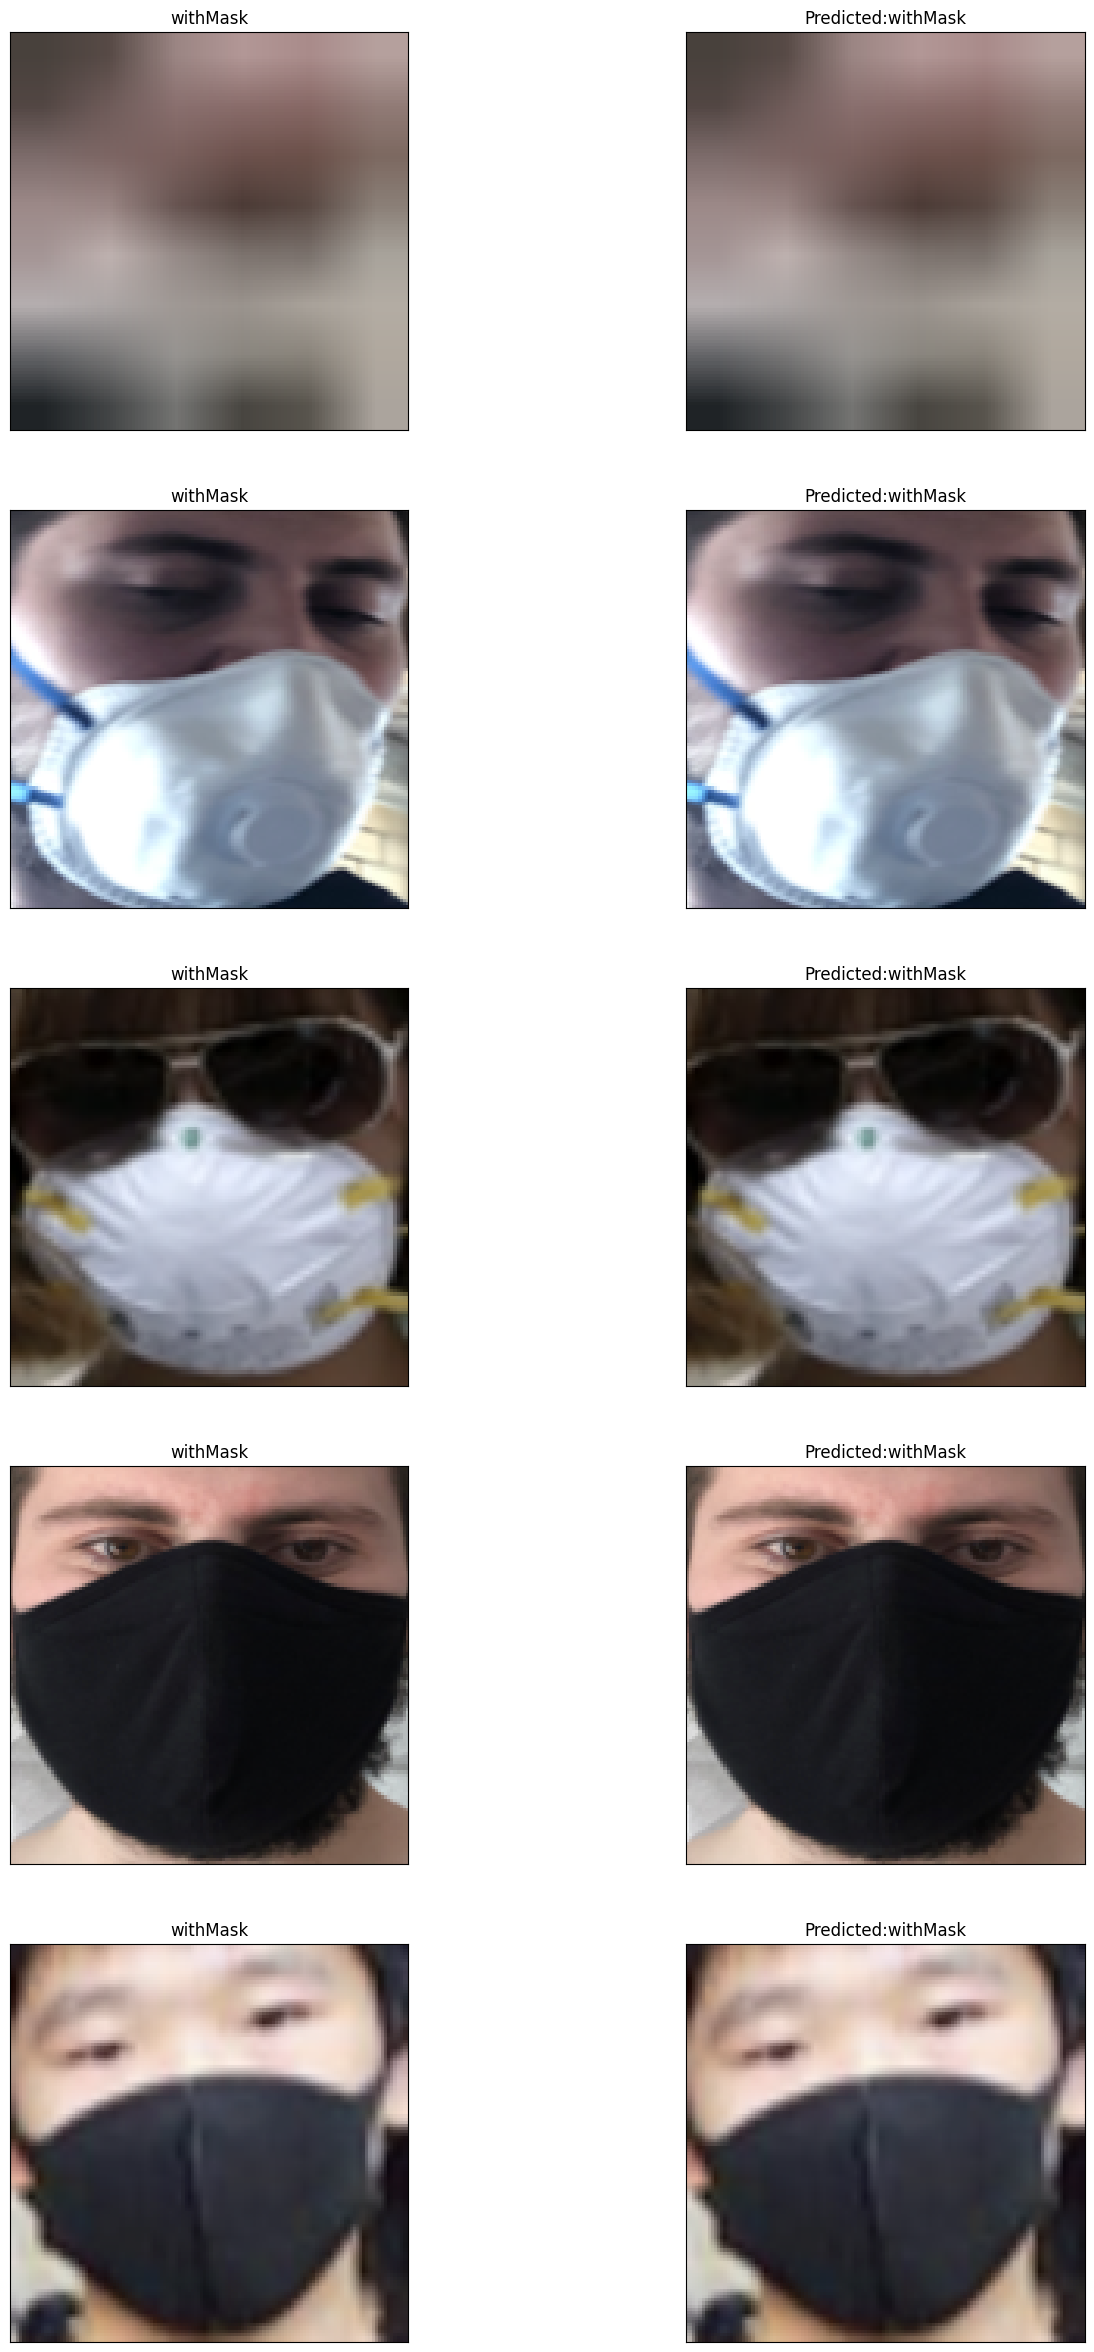

In [84]:
cnt = 5
show_results(Y_[:cnt], tar_cls[:cnt], X[:cnt])  # show first cnt results

# Error Analysis of the model

In [85]:
losses = myloss(Y_, tar_cls, reduction='none')  # reduction='none' returns loss for each image rather than the average 
losses.shape, losses[:5]

(torch.Size([816]),
 tensor([8.4765e-01, 2.7835e-01, 2.3333e-03, 1.6093e-05, 5.3762e-05]))

In [86]:
_,ix = (-losses).sort()

## Showing the worst mistakes done by the best model

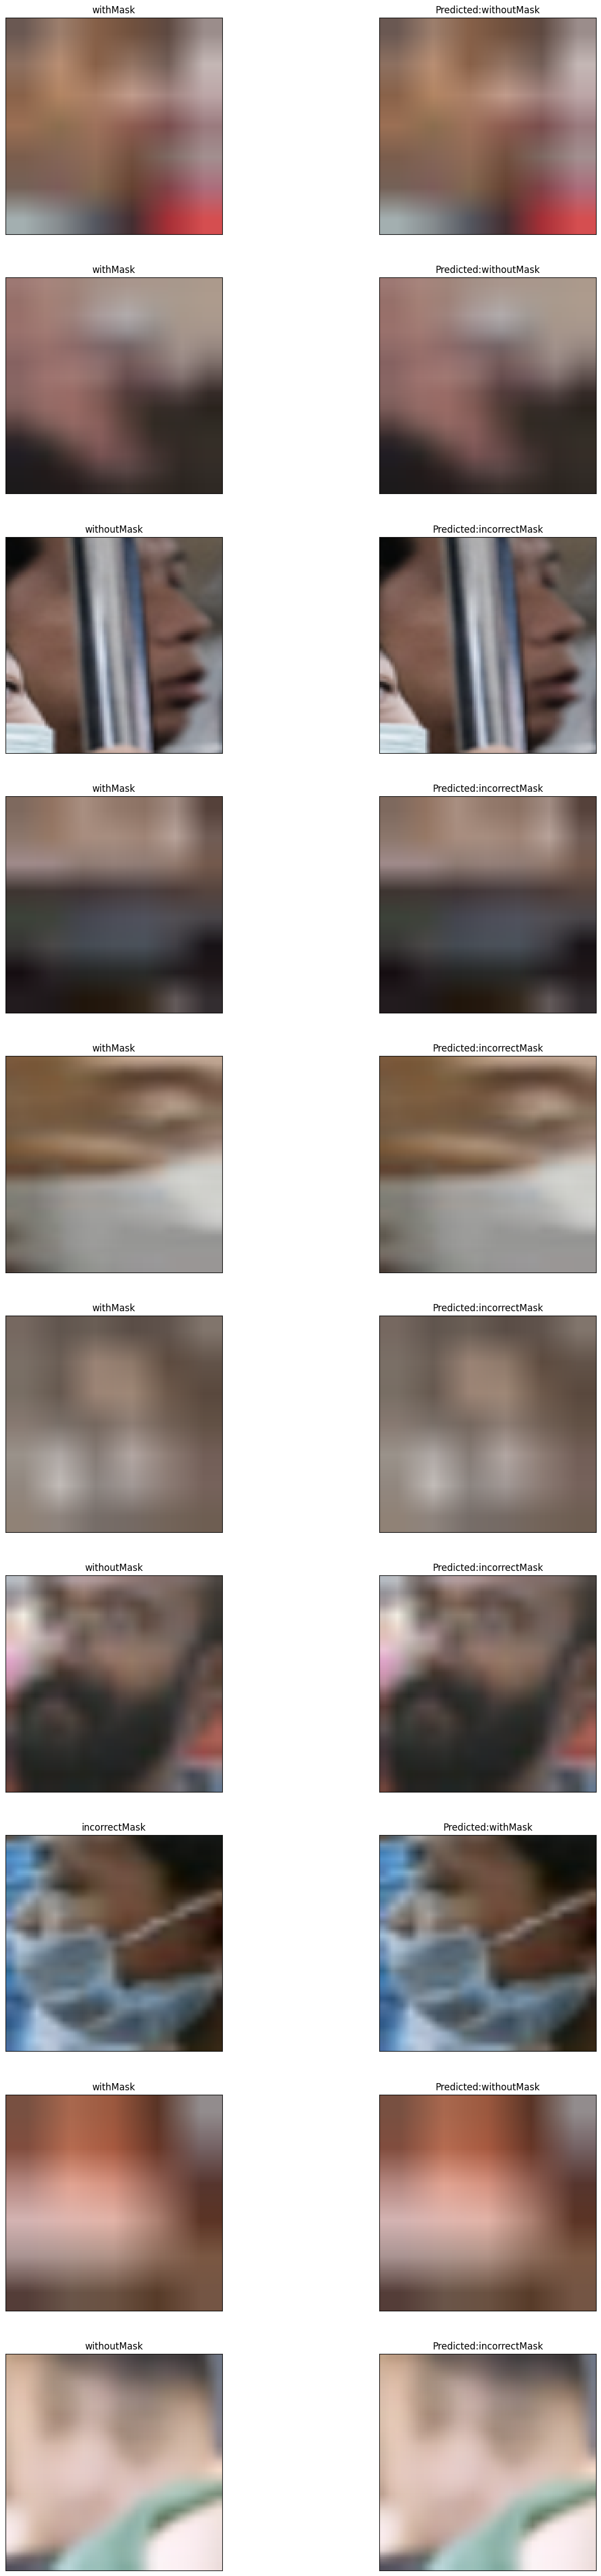

In [87]:
cnt = 10
show_results(Y_[ix[:cnt]], tar_cls[ix[:cnt]], X[ix[:cnt]])

# Using Deep Face library to detect faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=8bf36b9c3093cc74d83527669c16694af816a251e367621e174365e360bda8f2
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
Directory  /root /.deepface created
Directory  /root /.deepface/weights created


<Axes: >

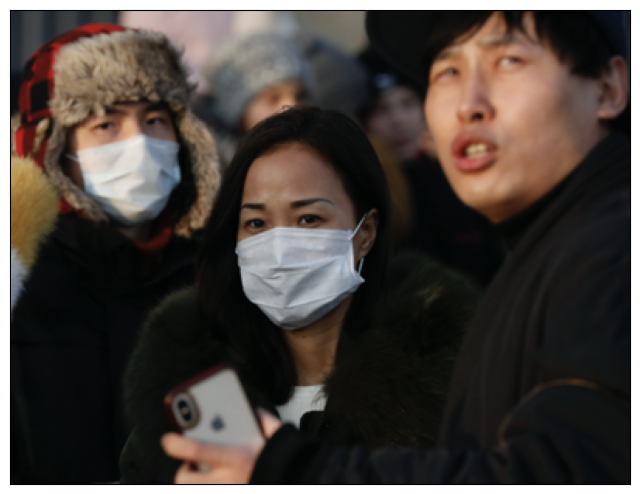

In [88]:
!pip install deepface
from deepface import DeepFace

img_path = dataDir.name + "/data/images/maksssksksss83.png"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_img(image)

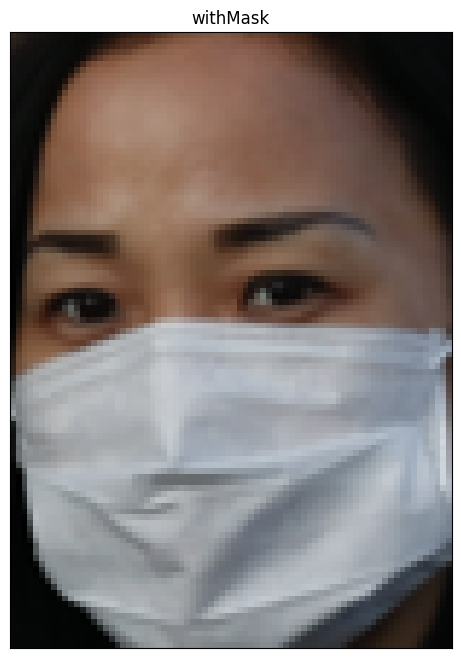

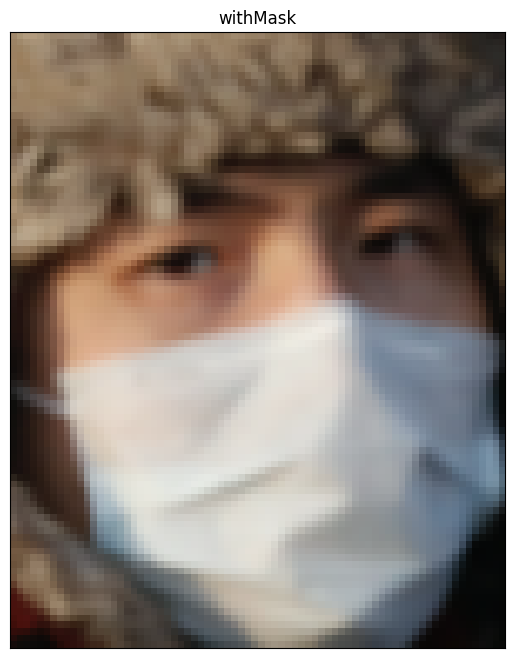

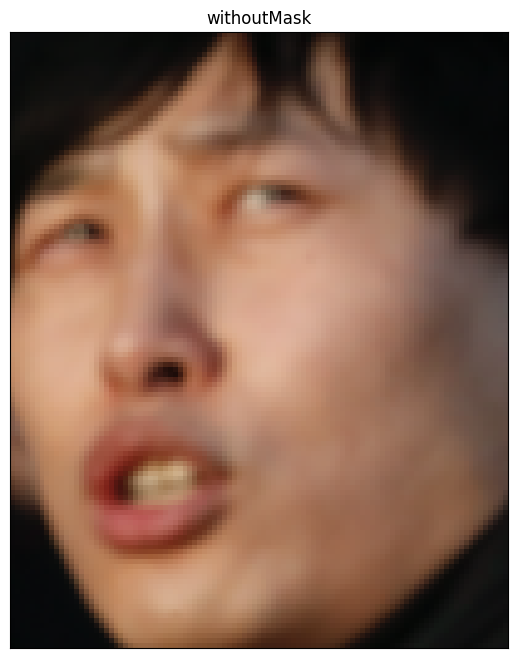

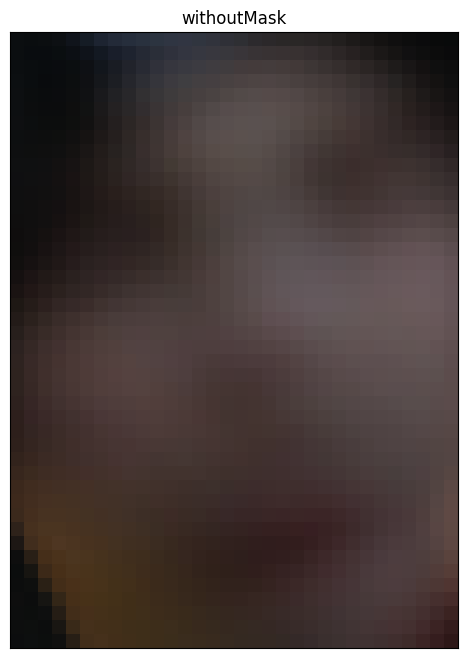

In [98]:
backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  'mediapipe'
]

face_objs = DeepFace.extract_faces(image, 
        target_size = (224, 224), 
        detector_backend = backends[4]
)

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transf = transforms.Compose([
      transforms.Resize((128, 128)),
      transforms.ToTensor(),
      transforms.Normalize(*imagenet_stats)
      ])
  
for f in face_objs:
  x = f['facial_area']['x'] 
  y = f['facial_area']['y']
  w = f['facial_area']['w']
  h = f['facial_area']['h']

  face = image[y:y+h,x:x+w,:]

  xb = transf(Image.fromarray(face))
  xb = xb.cuda()
  with tc.no_grad():
    y_ = best_model(xb.unsqueeze(0))

  show_img(face, title=i2c[y_.max(dim=1)[1]])

In [92]:
xb.shape

torch.Size([3, 128, 128])

In [93]:
xb = xb.cuda()

with tc.no_grad():
  y_ = best_model(xb.unsqueeze(0))

y_

tensor([[ 3.6314, -4.9997, -0.7005]], device='cuda:0')

In [96]:
i2c[y_.max(dim=1)[1]]

'withMask'